# Difference analysis

We use a subset of non-rare, non-short words.
We select all pairs of them that are mutually close in terms of edit distance.
For each such pair we take encode the difference between the pairs in such a way that
it lists the pieces that must be removed from and added to the first word in order to get the second word.

Then we list these diff-encodings by frequency, like this:

```
  #  freq   diff        examples
  ---------------------------------------------------------------------------------------------------------
  1: 148 -      + n|    Bengale~Bengalen, Chineese~Chineesen, Chinese~Chinesen
  2: 112 -      + en|   Chinees~Chineesen, Christen~Christenen, Engels~Engelsen
  3:  79 -      + e|    Atchins~Atchinse, Chinees~Chineese, Engels~Engelse
  4:  61 -      + de|   becomen~becomende, bedragen~bedragende, begon~begonde
  5:  61 -    e +       Chineese~Chinese, Chineesen~Chinesen, Deenen~Denen
  6:  53 -      + s|    Atchin~Atchins, Berckelangh~Berckelanghs, Coninc~Conincs
  7:  47 -  en| + t|    adviseeren~adviseert, antwoorden~antwoordt, arriveeren~arriveert
  8:  36 -  |ge +       gehouden~houden, gekeert~keert, geladen~laden
  9:  32 -      + |ver  antwoorden~verantwoorden, bieden~verbieden, brant~verbrant
 10:  28 -      + e     Nederlanderen~Neederlanderen, Nederlanders~Neederlanders, Nederlantse~Neederlantse
 11:  28 -    c + g     Almachtich~Almachtigh, affgevaerdicht~affgevaerdight, cleynicheden~cleynigheden
```

The idea is that the low frequency diffs are unimportant, but that the higher freqeuncy diffs are either
morphology, or spelling variation, or frequent OCR errors.

Having all these diffs in a compact overview is useful.

We can mark classify these diffs into morphology/variation/ocr-error.

Then we can go through all low-frequency words and diff them with neighbouring higher frequency words and see
whether they are a morphology/spelling/ocr variant of a higher frequency word.

Depending on what is the case, we can take action.

In order to produce a handy diff between words, we use the function
[editops(word1, word2)](https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html)
of the 
[Levenshtein module](https://pypi.org/project/python-Levenshtein/#documentation).

It gives a sequence of edit operations to change the word1 into word2.
We take that sequence and represent it by identifying which pieces of word1 must be left out and which pieces of word2
will be added to word2.
We also mark whether these pieces occur at the begin or end of word1/word2.
If several non-adjacent pieces have to be added or deleted we separate them by a `.`

You might need to do

```
pip3 install python-levenshtein
pip3 install text-fabric
```

In [1]:
import sys
import os
import collections
from math import log2
from Levenshtein import distance, editops
import numpy as np
import matplotlib.pyplot as plt

from tf.app import use
from tf.core.helpers import unexpanduser

# Graphics of frequency distributions

We use matplotlib to show the distribution of the diffs.

In [2]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

In [3]:
def showDist(freqs, maxBins=100, title="Frequencies", xitem="log-freqency", yitem="words"):
    values = np.fromiter((log2(f) for f in freqs.values()), float)
    (frequency, bins) = np.histogram(values, bins=100)
    fig, ax = plt.subplots()
    ax.hist(values, bins=maxBins)
    plt.gca().set(title=title, ylabel=yitem, xlabel=xitem)
    plt.show()

    nHapax = sum(1 for f in freqs.values() if f == 1)
    print(f"{len(freqs)} {yitem} of which {nHapax} with frequency 1")

# Corpus loading

We load volume 4 of the Daghregisters, which we have in Text-Fabric format.
Text-Fabric downloads it and loads it into memory as a result of the following call.

You get an extra global var `F` which gives you access to the feature information of the corpus.

In [17]:
# A = use("CLARIAH/wp6-daghregisters:clone", checkout="clone", hoist=globals())
A = use("CLARIAH/wp6-daghregisters", hoist=globals())

The requested TF-app is not available offline
	~/text-fabric-data/CLARIAH/wp6-daghregisters/app not found
rate limit is 5000 requests per hour, with 4999 left for this hour
	connecting to online GitHub repo CLARIAH/wp6-daghregisters ... connected
	app/__init__.py...downloaded
	app/config.yaml...downloaded
	app/static...directory
		app/static/display.css...downloaded
		app/static/logo.png...downloaded
	OK


The requested data is not available offline
	~/text-fabric-data/CLARIAH/wp6-daghregisters/tf/daghregister/004 not found
rate limit is 5000 requests per hour, with 4982 left for this hour
	connecting to online GitHub repo CLARIAH/wp6-daghregisters ... connected
	downloading https://github.com/CLARIAH/wp6-daghregisters/releases/download/v0.1/tf-daghregister-004-0.1.zip ... 
	unzipping ... 
	saving data


This is Text-Fabric 9.2.2
Api reference : https://annotation.github.io/text-fabric/tf/cheatsheet.html

14 features found and 0 ignored
   |     0.11s T otype                from ~/text-fabric-data/CLARIAH/wp6-daghregisters/tf/daghregister/004/0.1
   |     0.79s T oslots               from ~/text-fabric-data/CLARIAH/wp6-daghregisters/tf/daghregister/004/0.1
   |     1.32s T letters              from ~/text-fabric-data/CLARIAH/wp6-daghregisters/tf/daghregister/004/0.1
   |     1.12s T punc                 from ~/text-fabric-data/CLARIAH/wp6-daghregisters/tf/daghregister/004/0.1
   |     0.11s T n                    from ~/text-fabric-data/CLARIAH/wp6-daghregisters/tf/daghregister/004/0.1
   |      |     0.01s C __levels__           from otype, oslots, otext
   |      |     1.34s C __order__            from otype, oslots, __levels__
   |      |     0.08s C __rank__             from otype, __order__
   |      |     2.11s C __levUp__            from otype, oslots, __rank__
   |      |     0

We fetch all words.

We walk over all slot nodes, and for each slot node we retrieve the feature `letters` which contains the text of the
word at that node.

We then store the word in a dictionary, keyed by its text, and valued by the sequence of slot nodes
that have the same text.

In [5]:
wordOccs = collections.defaultdict(list)
for w in range(1, F.otype.maxSlot + 1):
    wordOccs[F.letters.v(w)].append(w)

print(f"{F.otype.maxSlot} word occurrences of {len(wordOccs)} distinct words")

229055 word occurrences of 24626 distinct words


This is all we need from Text-Fabric for now.

# Common words

We want to grab the words that are reasonably long (longer than `SIZE_THR`)
and not too rare (at least `FREQ_THR` occurrences)

In [6]:
FREQ_THR = 6
SIZE_THR = 5
DIST_THR = 5

In [7]:
WORDS_COMMON = sorted(
    word
    for (word, occs) in wordOccs.items()
    if len(occs) >= FREQ_THR and len(word) >= SIZE_THR
)
print(f"{len(WORDS_COMMON)} common words")

3029 common words


# Comparing words

We are going to compare the common words pairwise, and we store all pairs that are not to far apart
(their edit distance at most `DIST_THR`).

In [8]:
WORD_USED = set()
WORD_MATRIX = collections.defaultdict(dict)

nWords = len(WORDS_COMMON)
total = nWords * (nWords - 1) // 2
print(f"Computing {total} comparisons")

k = 0
c = 0
nPairs = 0
chunkSize = int(round(total / 100))

for i in range(nWords - 1):
    word1 = WORDS_COMMON[i]
    
    for j in range(i + 1, nWords):
        if c == chunkSize:
            c = 0
            sys.stdout.write(f"\r{k:>9} = {int(round(k / chunkSize)):>3} %")
        k += 1
        c += 1
        word2 = WORDS_COMMON[j]
        dist = distance(word1, word2)
        if dist <= DIST_THR:
            nPairs += 1
            WORD_MATRIX[word1][word2] = dist
            WORD_USED.add(word1)
            WORD_USED.add(word2)
sys.stdout.write(f"\r{k:>9} = {int(round(k / chunkSize)):>3} %")
print(f"\nStored {nPairs} word pairs between {len(WORD_USED)} words")

Computing 4585906 comparisons
  4585906 = 100 %
Stored 748926 word pairs between 3010 words


# Coding the diff

Here is the tricky part: we code the difference between a pair of words as a bunch of strings
in which they differ.

In [9]:
OPS = dict(replace="#", insert="+", delete="-")

def codeDiff(source, dest):
    ops = collections.defaultdict(list)
    for (op, iS, iD) in editops(source, dest):
        abb = OPS[op]
        if abb == "#":
            ops["-"].append(iS)
            ops["+"].append(iD)
        elif abb == "+":
            ops[abb].append(iD)
        elif abb == "-":
            ops[abb].append(iS)
    materialMin = ""
    prevI = len(source)
    endI = len(source) - 1
    for i in sorted(ops["-"]):
        pre = "|" if i == 0 else "." if i > prevI + 1 else ""
        post = "|" if i ==endI else ""
        materialMin += f"{pre}{source[i]}{post}"
        prevI = i
        
    materialPlus = ""
    prevI = len(dest)
    endI = len(dest) - 1
    for i in sorted(ops["+"]):
        pre = "|" if i == 0 else "." if i > prevI + 1 else ""
        post = "|" if i ==endI else ""
        materialPlus += f"{pre}{dest[i]}{post}"
        prevI = i
        
    return (materialMin, materialPlus)

## Examples

This function works for arbitrary word pairs, let's see a few examples:

In [10]:
examples = """
bakken gebakken
geloven verloven
haalt verhaald
nemen genomen
schip scbip
""".strip().split("\n")

for example in examples:
    (word1, word2) = example.split()
    print(f"{word1:<15} ==> {word2:<15} : {codeDiff(word1, word2)}") 

bakken          ==> gebakken        : ('', '|ge')
geloven         ==> verloven        : ('|g', '|v.r')
haalt           ==> verhaald        : ('t|', '|ver.d|')
nemen           ==> genomen         : ('e', '|ge.o')
schip           ==> scbip           : ('h', 'b')


# Many diffs

Now we will compute the diffs for all word pairs we have collected.

In [11]:
WORD_DIFF = collections.defaultdict(list)

print(f"Computing {nPairs} diffs between word pairs")
k = 0
c = 0
chunkSize = int(round(nPairs / 100))

for (word1, words2) in WORD_MATRIX.items():
    for word2 in words2:
        if c == chunkSize:
            c = 0
            sys.stdout.write(f"\r{k:>9} = {int(round(k / chunkSize)):>3} %")
        k += 1
        c += 1
        diff = codeDiff(word1, word2)
        WORD_DIFF[diff].append((word1, word2))
        
sys.stdout.write(f"\r{k:>9} = {int(round(k / chunkSize)):>3} %")
print(f"\n{len(WORD_DIFF)} distinct differences")

Computing 748926 diffs between word pairs
   748926 = 100 %
733371 distinct differences


Here is the distribution of the diffs:

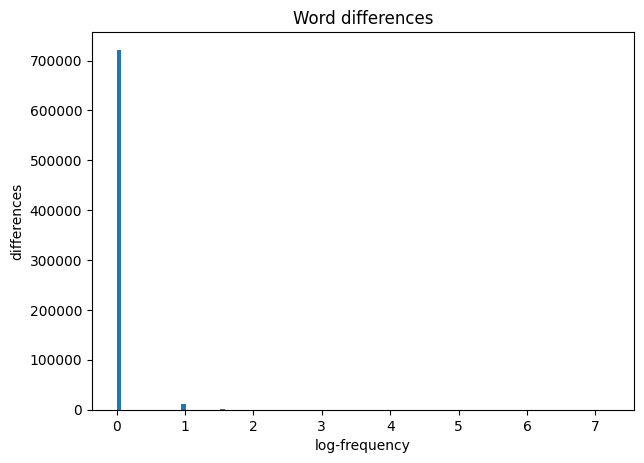

733371 differences of which 720668 with frequency 1


In [12]:
showDist(
    {d: len(pairs) for (d, pairs) in WORD_DIFF.items()},
    maxBins=100, title="Word differences", xitem="log-frequency", yitem="differences",
)

As expected, most differences are not interesting, since we have compared arbitrary words with
each other.
But if the same kind of change occurs more often, the frequency of that change will rise above
the background noise.

Let's see the top 100 diffs.

In [13]:
def showDiffs(fro, to):
    for (i, ((d, a), pairs)) in enumerate(sorted(WORD_DIFF.items(), key=lambda x: (-len(x[1]), x[0]))[fro:to]):
        freq = len(pairs)
        exampleRep = ", ".join("~".join(pair) for pair in pairs[0:3])
        print(f"{i + 1:>3}: {freq:>3} -{d:>5} + {a:<5} {exampleRep}")

In [14]:
showDiffs(0, 100)

  1: 148 -      + n|    Bengale~Bengalen, Chineese~Chineesen, Chinese~Chinesen
  2: 112 -      + en|   Chinees~Chineesen, Christen~Christenen, Engels~Engelsen
  3:  79 -      + e|    Atchins~Atchinse, Chinees~Chineese, Engels~Engelse
  4:  61 -      + de|   becomen~becomende, bedragen~bedragende, begon~begonde
  5:  61 -    e +       Chineese~Chinese, Chineesen~Chinesen, Deenen~Denen
  6:  53 -      + s|    Atchin~Atchins, Berckelangh~Berckelanghs, Coninc~Conincs
  7:  47 -  en| + t|    adviseeren~adviseert, antwoorden~antwoordt, arriveeren~arriveert
  8:  36 -  |ge +       gehouden~houden, gekeert~keert, geladen~laden
  9:  32 -      + |ver  antwoorden~verantwoorden, bieden~verbieden, brant~verbrant
 10:  28 -      + e     Nederlanderen~Neederlanderen, Nederlanders~Neederlanders, Nederlantse~Neederlantse
 11:  28 -    c + g     Almachtich~Almachtigh, affgevaerdicht~affgevaerdight, cleynicheden~cleynigheden
 12:  26 -    a + e     Backer~Becker, Macassar~Macasser, Pamalangh~Pamelangh
 

## Observations

Number 1 and 2 correspond to the regular plural in Dutch by appending `n` or `en`.

Up till 8 it is all inflection of nouns, adjectives and verbs.

9 deals with the productive prefix `ver` of many words.

11 is a spelling variation between `gh` and `ch`.

12 also seems to be a spelling variation, but `Backer` vs `Becker` could be a real difference.

20 is a freqent OCR error, confusion between `l` and `t`

57 is an OCR error, and a rather frequent one.

83 is strong verb morphology: the past tense of a strong verb

85 is not a variation but a matter of real differences between words.

## The tail

We show a bit of the long tail to show that little of importance happens here.

In [15]:
showDiffs(-50, None)

  1:   1 -|wiste| + |zyner| wiste~zyner
  2:   1 -|witt + |yser witte~ysere
  3:   1 -|witt + |zynd witte~zynde
  4:   1 -|witte| + |zulcx| witte~zulcx
  5:   1 -|witte| + |zynen| witte~zynen
  6:   1 -|witte| + |zyner| witte~zyner
  7:   1 - |woo + |zy   woonen~zynen
  8:   1 -|woo.d.n| + |yse  woorden~ysere
  9:   1 -|woo.en| + |zy.de| woonen~zynde
 10:   1 -|woo.n| + |zy.r| woonen~zyner
 11:   1 -|woo.t| + |yse.e| woort~ysere
 12:   1 -|woon.n| + |yser woonen~ysere
 13:   1 -|woor + |yeman woort~yemant
 14:   1 -|woor.n| + |zyn  woorden~zynde
 15:   1 -|woord + |zyn  woorden~zynen
 16:   1 -|woort| + |zulcx| woort~zulcx
 17:   1 -|woort| + |zynde| woort~zynde
 18:   1 -|woort| + |zynen| woort~zynen
 19:   1 -|woort| + |zyner| woort~zyner
 20:   1 -|wor.n| + |zyn  worden~zynde
 21:   1 -|wor.t| + |zyn.e| wordt~zynde
 22:   1 -|word + |yeman wordt~yemant
 23:   1 -|word + |zyn  worden~zynen
 24:   1 -|word.n| + |yser worden~ysere
 25:   1 -|word.n| + |zyn.r| worden~zyner
 26:   1 -|wo

# Back to the top

To finish off,
we show more examples from the top.

If you skim through it, you see many instances of morphology that happens in 17th century Dutch that you might not be]aware of.

And, when the frequency lowers to 3 and below, the cases become more and more tenuous.

In [16]:
showDiffs(100, 500)

  1:   6 - cht| + gen|  beweecht~beweegen, gelecht~gelegen, jacht~jagen
  2:   6 -  ch| + gen|  eenich~eenigen, hooch~hoogen, jegenwoordich~jegenwoordigen
  3:   6 -    d + n.n|  badde~banden, begonde~begonnen, conde~connen
  4:   6 -    e + de|   betaelen~betalende, laeten~latende, neemen~nemende
  5:   6 -   ee + y     begreepen~begrypen, bleeven~blyven, meenen~mynen
  6:   6 -  en| + ste|  aencomen~aencomste, comen~comste, dienen~dienste
  7:   6 -   e| + |ver.t| andere~verandert, deele~verdeelt, hoope~verhoopt
  8:   6 -    g + st    aengaende~aenstaende, begaen~bestaen, gegaen~gestaen
  9:   6 -    l + r     geladen~geraden, haelen~haeren, halen~haren
 10:   6 -    o + ra    bocht~bracht, stoffen~straffen, stond~strand
 11:   6 -   |G + |g    Gelyck~gelyck, Gemelte~gemelte, Generael~generael
 12:   6 -|ge.e + a     geleden~laden, gelegen~lagen, gemeent~maent
 13:   6 -   |h + |l    handen~landen, handt~landt, hangen~langen
 14:   6 - |h.l + |w.r  haelen~waeren, halen~waren, helpen